# Time Series Forecasting

<img src="https://cdn.prod.website-files.com/64a7eed956ba9b9a3c62401d/64a80371696fdd543e06257a_Orange-and-green-chart-on-blue-background.webp" width=700>

### Dataset Download  
You can download the CSV file here:  
[https://www.kaggle.com/competitions/tabular-playground-series-jan-2022/data)

### Introduction
The goal of this project is to forecast daily product sales using historical sales data.
The dataset contains time-based patterns such as weekly seasonality, yearly trends, and strong peaks during special periods.
To capture these patterns, both classical time series models and machine learning models were tested.
First, a SARIMAX model was used as a statistical baseline.
Then, two machine learning models, LightGBM and CatBoost, were trained using engineered time features and lag variables.
Model performance was evaluated using SMAPE, and visual comparisons were used to analyze forecast quality and residual behavior.

### Import Libraries

In [81]:
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from datetime import date,timedelta
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
import datetime
import joblib
import json
import warnings
warnings.filterwarnings("ignore")

### Load Data

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [3]:
train.head()

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


In [4]:
train.tail()

,row_id,date,country,store,product,num_sold
26293,26293,2018-12-31,Sweden,KaggleMart,Kaggle Hat,823
26294,26294,2018-12-31,Sweden,KaggleMart,Kaggle Sticker,250
26295,26295,2018-12-31,Sweden,KaggleRama,Kaggle Mug,1004
26296,26296,2018-12-31,Sweden,KaggleRama,Kaggle Hat,1441
26297,26297,2018-12-31,Sweden,KaggleRama,Kaggle Sticker,388


In [5]:
test.head()

,row_id,date,country,store,product
0,26298,2019-01-01,Finland,KaggleMart,Kaggle Mug
1,26299,2019-01-01,Finland,KaggleMart,Kaggle Hat
2,26300,2019-01-01,Finland,KaggleMart,Kaggle Sticker
3,26301,2019-01-01,Finland,KaggleRama,Kaggle Mug
4,26302,2019-01-01,Finland,KaggleRama,Kaggle Hat


In [6]:
test.tail()

,row_id,date,country,store,product
6565,32863,2019-12-31,Sweden,KaggleMart,Kaggle Hat
6566,32864,2019-12-31,Sweden,KaggleMart,Kaggle Sticker
6567,32865,2019-12-31,Sweden,KaggleRama,Kaggle Mug
6568,32866,2019-12-31,Sweden,KaggleRama,Kaggle Hat
6569,32867,2019-12-31,Sweden,KaggleRama,Kaggle Sticker


In [7]:
train.shape

(26298, 6)

In [8]:
test.shape

(6570, 5)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26298 entries, 0 to 26297
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    26298 non-null  int64 
 1   date      26298 non-null  object
 2   country   26298 non-null  object
 3   store     26298 non-null  object
 4   product   26298 non-null  object
 5   num_sold  26298 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.2+ MB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6570 entries, 0 to 6569
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   row_id   6570 non-null   int64 
 1   date     6570 non-null   object
 2   country  6570 non-null   object
 3   store    6570 non-null   object
 4   product  6570 non-null   object
dtypes: int64(1), object(4)
memory usage: 256.8+ KB


In [11]:
train.isna().mean()

row_id      0.0
date        0.0
country     0.0
store       0.0
product     0.0
num_sold    0.0
dtype: float64

In [12]:
test.isna().mean()

row_id     0.0
date       0.0
country    0.0
store      0.0
product    0.0
dtype: float64

In [13]:
train['country'].value_counts()

country
Finland    8766
Norway     8766
Sweden     8766
Name: count, dtype: int64

In [14]:
train['store'].value_counts()

store
KaggleMart    13149
KaggleRama    13149
Name: count, dtype: int64

In [15]:
train['product'].value_counts()

product
Kaggle Mug        8766
Kaggle Hat        8766
Kaggle Sticker    8766
Name: count, dtype: int64

### Feature Engineering

In [16]:
for d in [train, test]:
    d['date'] = pd.to_datetime(d['date'])

    d['year'] = d['date'].dt.year
    d['month'] = d['date'].dt.month
    d['week'] = d['date'].dt.isocalendar().week.astype(int)
    d['dayofweek'] = d['date'].dt.dayofweek
    d['is_weekend'] = (d['dayofweek'] >= 5).astype(int)
    d['dayofyear'] = d['date'].dt.dayofyear

In [17]:
train=train.sort_values(['country', 'store', 'product', 'date']).reset_index(drop=True)
test =test.sort_values(['country', 'store', 'product', 'date']).reset_index(drop=True)

In [18]:
full=pd.concat([train, test], axis=0, ignore_index=True)
full=full.sort_values(['country', 'store', 'product', 'date']).reset_index(drop=True)

In [19]:
YEAR_LAGS=[364, 365, 371]

for lag in YEAR_LAGS:full[f'lag_{lag}'] = (full.groupby(['country', 'store', 'product'])['num_sold'].shift(lag))

In [20]:
train_fe=full[full['num_sold'].notna()].copy()
test_fe=full[full['num_sold'].isna()].copy()
train_fe=train_fe.dropna().reset_index(drop=True)

In [21]:
print(train_fe.shape, test_fe.shape)
print(test_fe.filter(like='lag_').isna().sum().head())
print(test_fe.filter(like='rolling_').isna().sum().head())
test_fe.info()

(19620, 15) (6570, 15)
lag_364    18
lag_365     0
lag_371     0
dtype: int64
Series([], dtype: float64)
<class 'pandas.core.frame.DataFrame'>
Index: 6570 entries, 1461 to 32867
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   row_id      6570 non-null   int64         
 1   date        6570 non-null   datetime64[ns]
 2   country     6570 non-null   object        
 3   store       6570 non-null   object        
 4   product     6570 non-null   object        
 5   num_sold    0 non-null      float64       
 6   year        6570 non-null   int32         
 7   month       6570 non-null   int32         
 8   week        6570 non-null   int64         
 9   dayofweek   6570 non-null   int32         
 10  is_weekend  6570 non-null   int64         
 11  dayofyear   6570 non-null   int32         
 12  lag_364     6552 non-null   float64       
 13  lag_365     6570 non-null   float64       
 14  lag_371     6570

### Time-Based Analysis

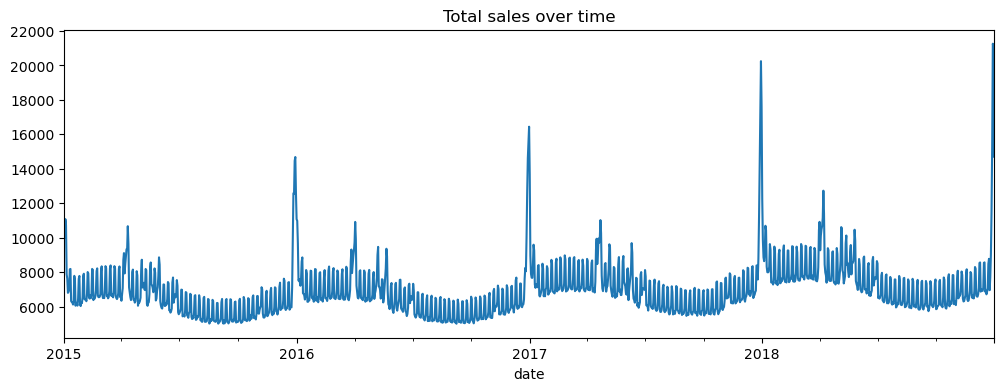

In [22]:
daily_total=train.groupby('date')['num_sold'].sum()
daily_total.plot(figsize=(12,4), title='Total sales over time');

Total sales show a clear long-term upward trend with strong seasonal fluctuations and recurring peaks.

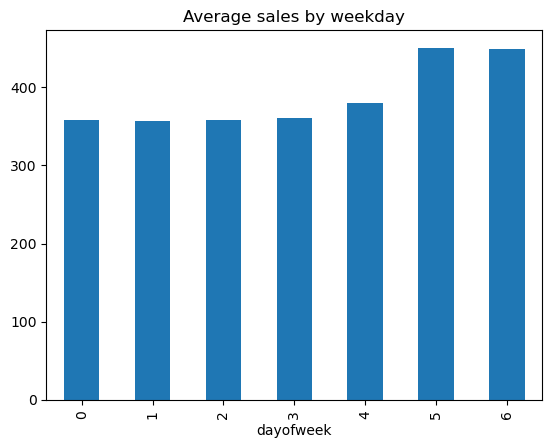

In [72]:
train['dayofweek']=train['date'].dt.dayofweek
train['month']=train['date'].dt.month

train.groupby('dayofweek')['num_sold'].mean().plot(kind='bar', title='Average sales by weekday');

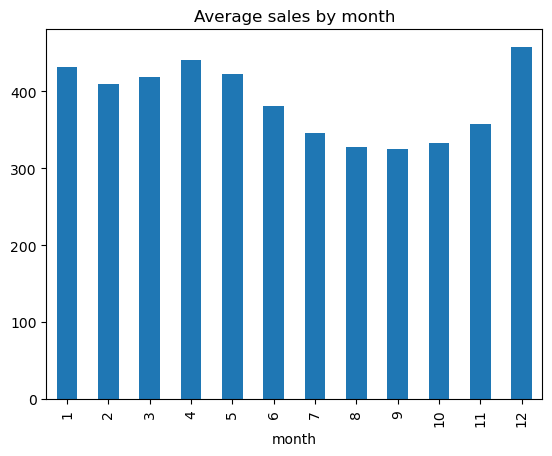

In [73]:
train.groupby('month')['num_sold'].mean().plot(kind='bar', title='Average sales by month');

Die Monatsdurchschnitte zeigen eine klare Saisonalität mit höheren Verkäufen in bestimmten Monaten und schwächeren Sommermonaten.

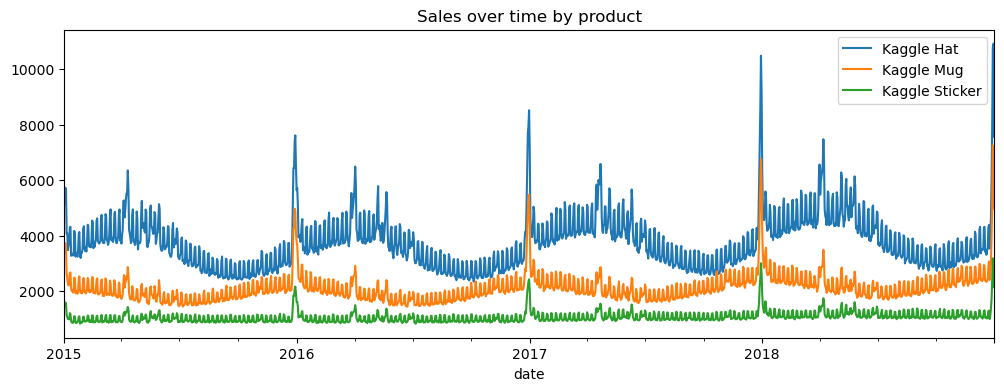

In [24]:
for p in train['product'].unique():
    tmp = train[train['product'] == p].groupby('date')['num_sold'].sum()
    tmp.plot(label=p, figsize=(12,4))

plt.legend()
plt.title('Sales over time by product');

All products follow similar seasonal patterns but differ significantly in their overall sales levels.

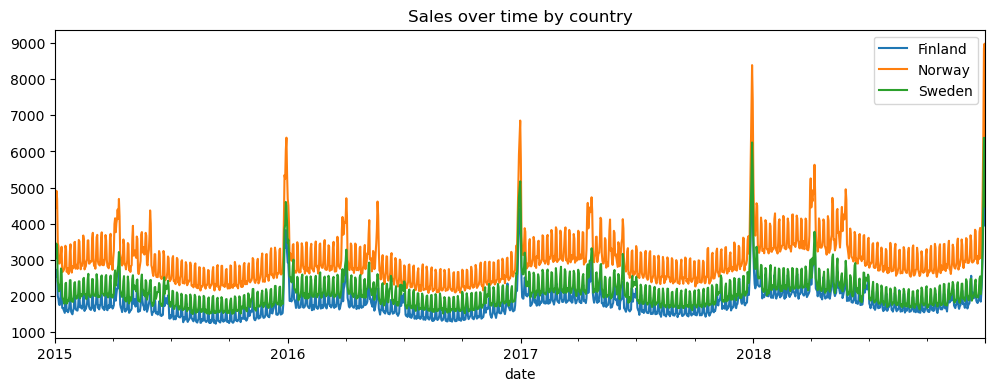

In [25]:
for c in train['country'].unique():
    tmp = train[train['country'] == c].groupby('date')['num_sold'].sum()
    tmp.plot(label=c, figsize=(12,4))

plt.legend()
plt.title('Sales over time by country');

Sales trends are similar across countries, but the base demand level and peak intensity differ.

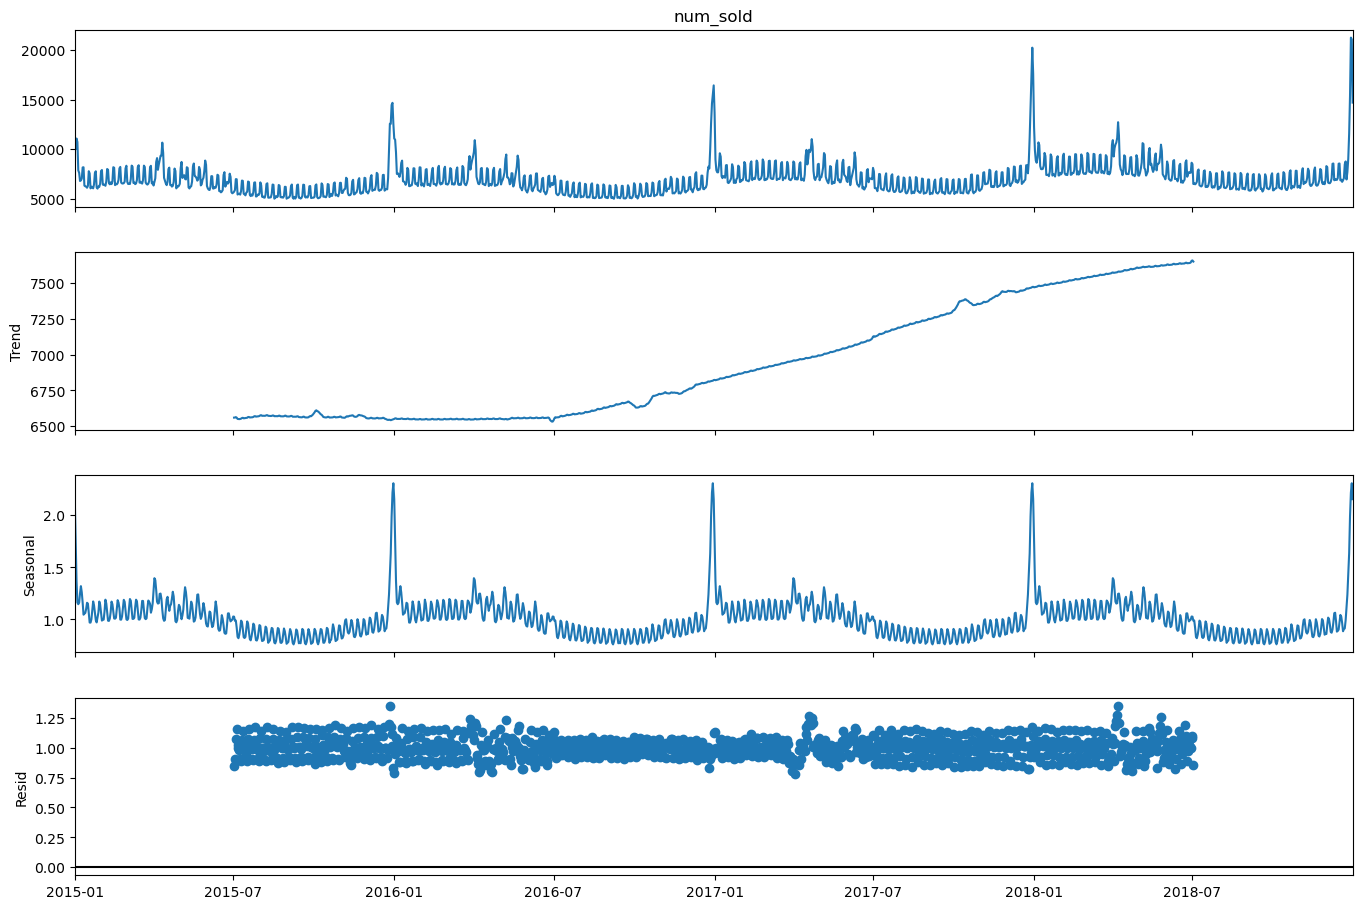

In [26]:
ts=(train.groupby('date')['num_sold'].sum().asfreq('D'))
result=seasonal_decompose(ts, model='multiplicative', period=365)

fig=result.plot()
fig.set_size_inches(15, 10)

The decomposition shows a steadily increasing trend, strong yearly seasonality, and mostly random residuals.

### Modelling SARIMAX

In [27]:
ts=(train.groupby('date')['num_sold'].sum().asfreq('D').fillna(0))

In [28]:
train_ts=ts[:'2018-06-30']
val_ts=ts['2018-07-01':]

In [29]:
model=SARIMAX(train_ts,order=(1,1,1),seasonal_order=(0,0,0,0),enforce_stationarity=False,enforce_invertibility=False)

In [30]:
res=model.fit(disp=False)

In [31]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               num_sold   No. Observations:                 1277
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -10310.390
Date:                Sun, 28 Dec 2025   AIC                          20626.780
Time:                        07:55:21   BIC                          20642.230
Sample:                    01-01-2015   HQIC                         20632.582
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4741      0.035    -13.358      0.000      -0.544      -0.405
ma.L1          0.8971      0.021     41.975      0.000       0.855       0.939
sigma2      7.011e+05   2.76e+04     25.424      0.000    6.47e+05    7.55e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.35   Jarque-Bera (JB):                53.04
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               1.33   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
tahmin=res.forecast(len(val_ts))

def smape(y_true, y_pred):
    return 100 * (abs(y_pred - y_true) / (abs(y_true) + abs(y_pred))).mean()

smape_score=smape(val_ts.values, tahmin.values)

In [33]:
smape_score

np.float64(14.38702454517293)

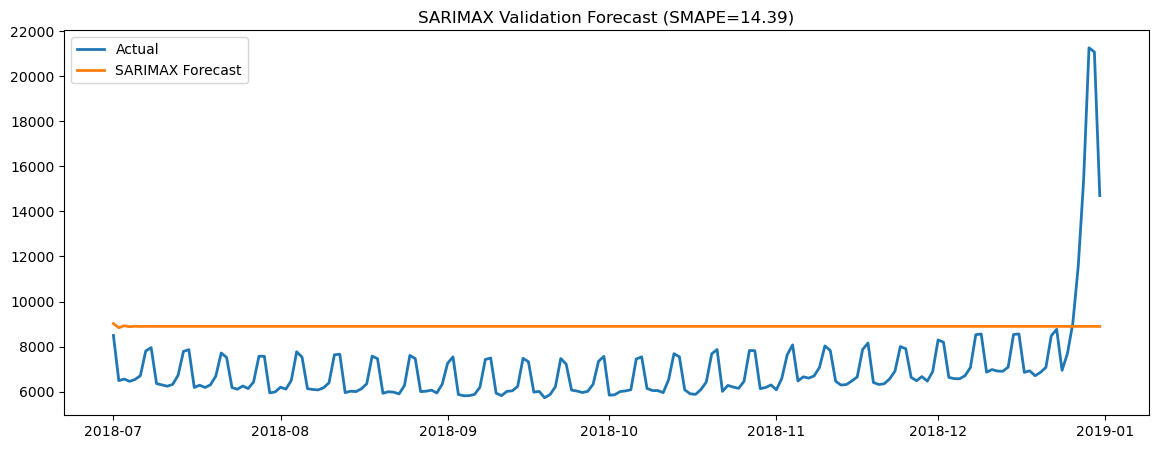

In [34]:
plt.figure(figsize=(14,5))
plt.plot(val_ts.index, val_ts.values, label='Actual', linewidth=2)
plt.plot(val_ts.index, tahmin.values, label='SARIMAX Forecast', linewidth=2)
plt.title(f'SARIMAX Validation Forecast (SMAPE={smape_score:.2f})')
plt.legend()
plt.show()

The SARIMAX model captures seasonality only partially and underestimates sharp peaks, resulting in a higher SMAPE.

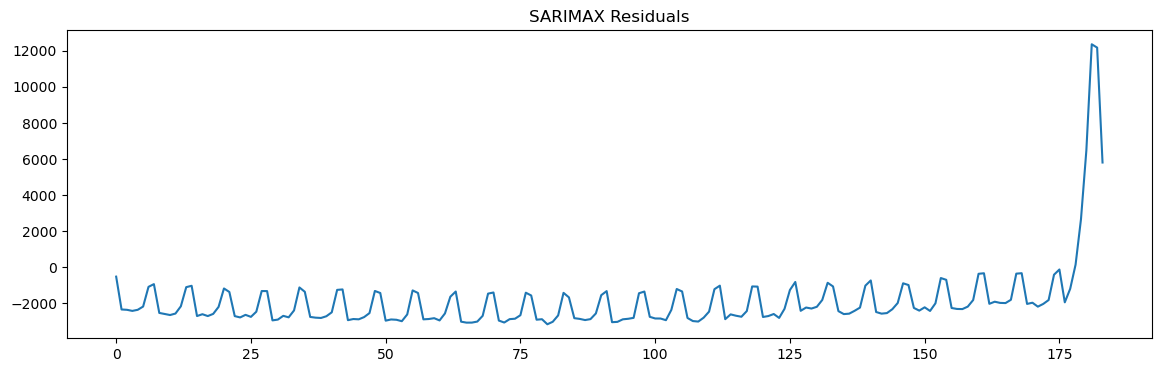

In [74]:
residuals=val_ts.values - tahmin.values

plt.figure(figsize=(14,4))
plt.plot(residuals)
plt.title('SARIMAX Residuals')
plt.show()

Residuals display structured patterns, indicating that important dynamics remain unmodeled.

##### Modelling ML

In [36]:
TARGET='num_sold'

FEATURES=[
    'year','month','week','dayofweek','is_weekend','dayofyear',
    'lag_364','lag_365','lag_371',
    'country','store','product'
]

In [37]:
cat_cols=['country','store','product']

encoders={}
for c in cat_cols:
    le = LabelEncoder()
    train_fe[c]=le.fit_transform(train_fe[c].astype(str))
    test_fe[c] =le.transform(test_fe[c].astype(str))
    encoders[c]=le

In [38]:
split_date='2018-07-01'

tr=train_fe[train_fe['date'] < split_date].copy()
va=train_fe[train_fe['date'] >= split_date].copy()

x_train=tr[FEATURES]
y_train=tr[TARGET].values

x_val=va[FEATURES]
y_val=va[TARGET].values

In [39]:
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred))
    denom = np.where(denom == 0, 1.0, denom)
    return 100.0 * np.mean(np.abs(y_pred - y_true) / denom)

In [40]:
test_fe[FEATURES].isna().sum().sum()

np.int64(18)

In [41]:
num_cols=[c for c in FEATURES if c not in cat_cols]
fill_map=train_fe[num_cols].median()
test_fe[num_cols]=test_fe[num_cols].fillna(fill_map)

In [42]:
test_fe[FEATURES].isna().sum().sum()

np.int64(0)

##### CatBoost Model

In [43]:
cat_cols=['country', 'store', 'product']

tr_cb=tr.copy()
va_cb=va.copy()

for c in cat_cols:
    tr_cb[c]=tr_cb[c].astype(str)
    va_cb[c]=va_cb[c].astype(str)

x_train_cb=tr_cb[FEATURES]
y_train_cb=tr_cb[TARGET].values

x_val_cb=va_cb[FEATURES]
y_val_cb=va_cb[TARGET].values

In [44]:
cat_idx=[FEATURES.index(c) for c in cat_cols] 

In [45]:
modelcb=CatBoostRegressor(iterations=5000,learning_rate=0.05,depth=8,loss_function='MAE',random_seed=42,verbose=200)

In [46]:
modelcb.fit(x_train_cb, y_train_cb,eval_set=(x_val_cb, y_val_cb),cat_features=cat_idx,use_best_model=True)

0:	learn: 189.7870819	test: 173.3003008	best: 173.3003008 (0)	total: 186ms	remaining: 15m 31s
200:	learn: 23.7449657	test: 27.8280260	best: 26.9714787 (179)	total: 11.3s	remaining: 4m 29s
400:	learn: 20.3641707	test: 27.9461176	best: 26.9714787 (179)	total: 23.8s	remaining: 4m 33s
600:	learn: 18.7638536	test: 27.9669756	best: 26.9714787 (179)	total: 35.2s	remaining: 4m 17s
800:	learn: 17.5524408	test: 28.1989164	best: 26.9714787 (179)	total: 46.7s	remaining: 4m 4s
1000:	learn: 16.6542091	test: 28.1940798	best: 26.9714787 (179)	total: 57.6s	remaining: 3m 50s
1200:	learn: 15.9584849	test: 28.2952083	best: 26.9714787 (179)	total: 1m 9s	remaining: 3m 40s
1400:	learn: 15.4023574	test: 28.3997500	best: 26.9714787 (179)	total: 1m 21s	remaining: 3m 28s
1600:	learn: 14.9595488	test: 28.3460328	best: 26.9714787 (179)	total: 1m 33s	remaining: 3m 17s
1800:	learn: 14.5484383	test: 28.4397950	best: 26.9714787 (179)	total: 1m 46s	remaining: 3m 8s
2000:	learn: 14.1983401	test: 28.4510404	best: 26.9714

In [47]:
tahmin3=modelcb.predict(x_val_cb)
smape_cb=smape(y_val_cb, tahmin3)
smape_cb

np.float64(3.5088492834440834)

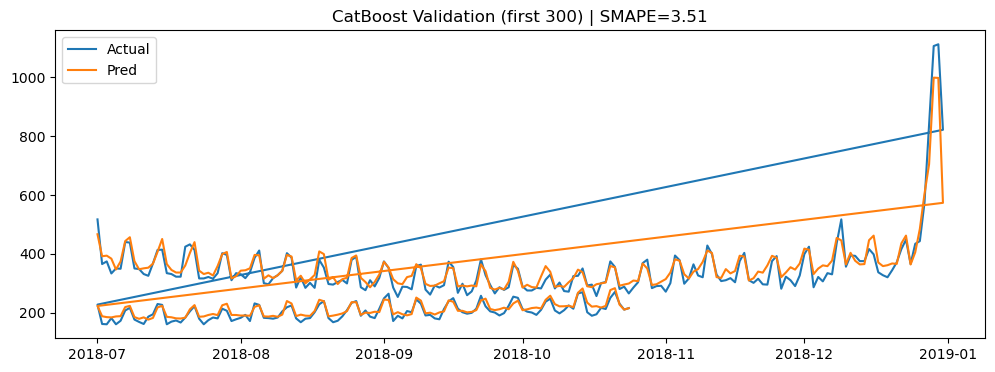

In [48]:
plt.figure(figsize=(12,4))
plt.plot(va['date'][:300], y_val_cb[:300], label='Actual')
plt.plot(va['date'][:300], tahmin3[:300], label='Pred')
plt.title(f'CatBoost Validation (first 300) | SMAPE={smape_cb:.2f}')
plt.legend()
plt.show()

CatBoost follows the actual values well but shows small deviations during strong upward movements.

##### LGBMRegressor

In [49]:
modellg=lgb.LGBMRegressor(n_estimators=5000,learning_rate=0.03,num_leaves=64,subsample=0.8,colsample_bytree=0.8,random_state=42)

In [50]:
modellg.fit(x_train, y_train,eval_set=[(x_val, y_val)],eval_metric='l1',callbacks=[lgb.early_stopping(200, verbose=False)])

  File "C:\Users\enesy\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\enesy\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\enesy\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\enesy\anaconda3\Lib\subprocess.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1107
[LightGBM] [Info] Number of data points in the train set: 16308, number of used features: 12
[LightGBM] [Info] Start training from score 395.520297


,boosting_type,'gbdt'
,num_leaves,64
,max_depth,-1
,learning_rate,0.03
,n_estimators,5000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [51]:
tahmin2=modellg.predict(x_val)
smape_val=smape(y_val, tahmin2)
smape_val

np.float64(3.3628013080621555)

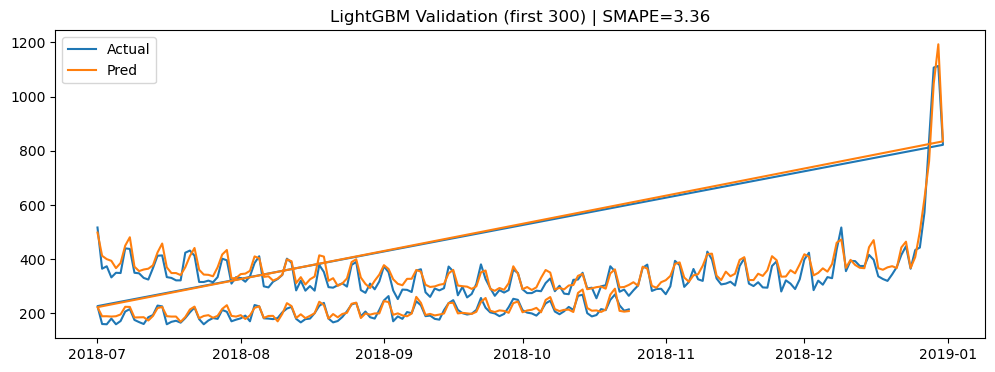

In [52]:
plt.figure(figsize=(12,4))
plt.plot(va['date'][:300],y_val[:300],label='Actual')
plt.plot(va['date'][:300],tahmin2[:300],label='Pred')
plt.title(f'LightGBM Validation (first 300) | SMAPE={smape_val:.2f}')
plt.legend()
plt.show()

LightGBM accurately captures both trend and seasonality and achieves the best validation performance.

In [53]:
print(x_train.isna().sum().sum(), x_val.isna().sum().sum(), test_fe[FEATURES].isna().sum().sum())

0 0 0


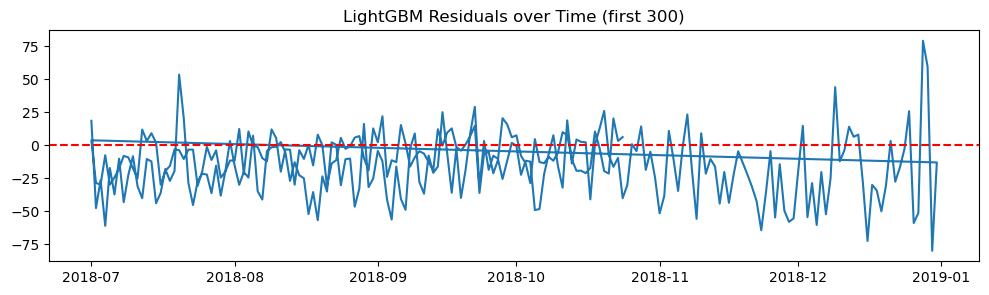

In [54]:
residuals=y_val - tahmin2

plt.figure(figsize=(12,3))
plt.plot(va['date'][:300], residuals[:300])
plt.axhline(0, color='red', linestyle='--')
plt.title('LightGBM Residuals over Time (first 300)')
plt.show()

Residuals are centered around zero without a visible trend, suggesting a well-fitted model.

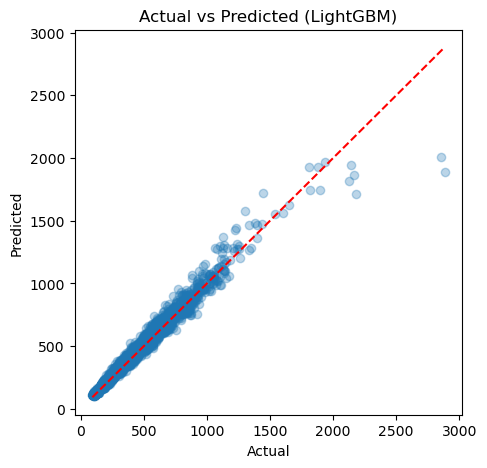

In [55]:
plt.figure(figsize=(5,5))
plt.scatter(y_val, tahmin2, alpha=0.3)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         '--r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (LightGBM)')
plt.show()

Predicted values closely align with actual values, indicating high predictive accuracy.

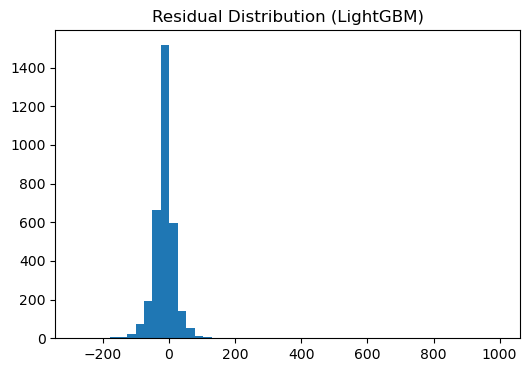

In [56]:
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=50)
plt.title('Residual Distribution (LightGBM)')
plt.show()

Residuals are approximately normally distributed and centered around zero.

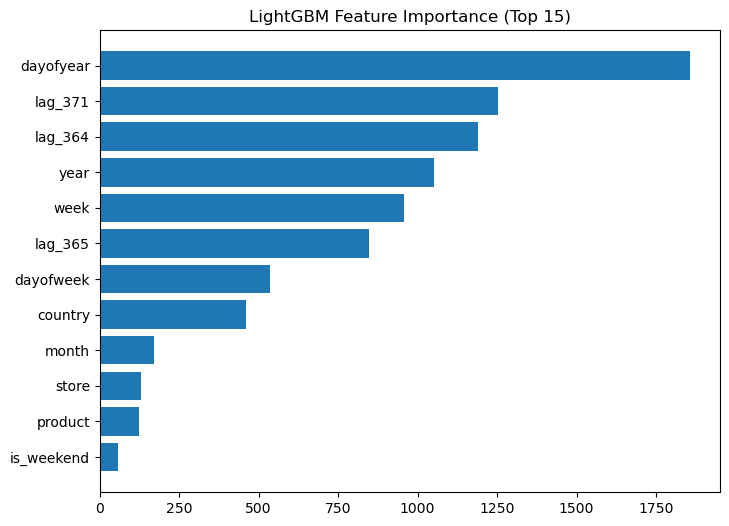

In [57]:
imp = pd.DataFrame({
    'feature': x_train.columns,
    'importance': modellg.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8,6))
plt.barh(imp['feature'][:15], imp['importance'][:15])
plt.gca().invert_yaxis()
plt.title('LightGBM Feature Importance (Top 15)')
plt.show()

Time-based features and lag variables are the most important drivers of sales predictions.

### Test

In [58]:
sub=pd.read_csv('sample_submission.csv')

In [59]:
sub.head()

,row_id,num_sold
0,26298,100
1,26299,100
2,26300,100
3,26301,100
4,26302,100


In [60]:
test_pred=modellg.predict(test_fe[FEATURES])

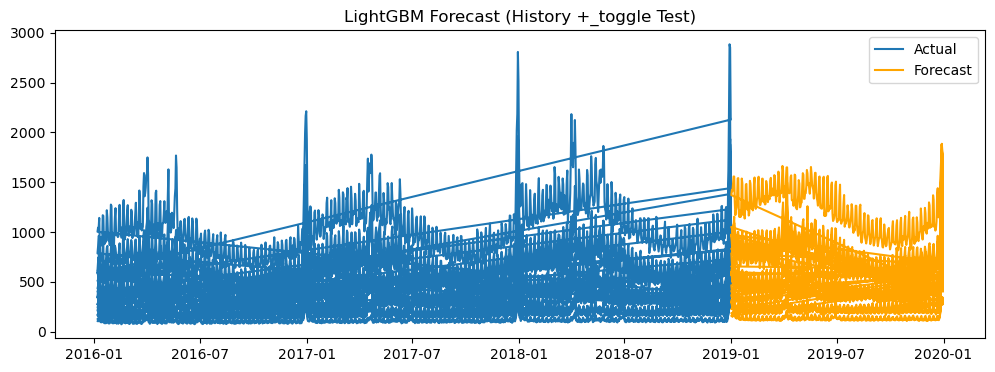

In [61]:
plt.figure(figsize=(12,4))
plt.plot(train_fe['date'], train_fe['num_sold'], label='Actual')
plt.plot(test_fe['date'], test_pred, color='orange', label='Forecast')
plt.title('LightGBM Forecast (History +_toggle Test)')
plt.legend()
plt.show()

The model extends learned seasonal patterns consistently into the future.

In [62]:
submission=pd.DataFrame({'row_id': test_fe['row_id'],'num_sold': test_pred})

In [63]:
submission.to_csv('submission_lgbm.csv',index=False)

In [64]:
print(submission.shape)
print(submission.head())
print(submission.isna().sum())

(6570, 2)
      row_id    num_sold
1461   26299  598.636723
1462   26317  550.342791
1463   26335  500.371235
1464   26353  474.767957
1465   26371  577.643696
row_id      0
num_sold    0
dtype: int64


In [65]:
print('rows ok:', len(submission) == len(sub))
print('ids ok:', submission['row_id'].equals(sub['row_id']))

rows ok: True
ids ok: False


In [66]:
submission.head()

,row_id,num_sold
1461,26299,598.636723
1462,26317,550.342791
1463,26335,500.371235
1464,26353,474.767957
1465,26371,577.643696


In [68]:
sub = pd.read_csv('sample_submission.csv')

print('rows match:', len(submission) == len(sub))
print('same row_ids set:', set(submission['row_id']) == set(sub['row_id']))
print('same order:', submission['row_id'].equals(sub['row_id']))

rows match: True
same row_ids set: True
same order: False


In [69]:
sub = pd.read_csv('sample_submission.csv')
submission = sub[['row_id']].merge(submission, on='row_id', how='left')
submission.to_csv('submission_lgbm.csv', index=False)

In [71]:
print(submission['row_id'].equals(sub['row_id']))

True


In [77]:
joblib.dump(modellg, 'model_lgbm.pkl')

['model_lgbm.pkl']

In [78]:
joblib.dump(FEATURES, 'feature_names.pkl')

['feature_names.pkl']

In [79]:
joblib.dump(encoders, 'encoders.pkl')

['encoders.pkl']

In [80]:
cat_cols=['country', 'store', 'product']
num_cols=[c for c in FEATURES if c not in cat_cols]

fill_map=train_fe[num_cols].median().to_dict()
joblib.dump(fill_map, 'fill_map.pkl')

['fill_map.pkl']

In [82]:
meta={
    'model': 'LightGBMRegressor',
    'target': TARGET,
    'validation_smape': 3.36,
    'features': FEATURES
}

with open('meta.json', 'w') as f:
    json.dump(meta, f, indent=2)

### Conclusion
The SARIMAX model could follow the general trend, but it could not handle strong seasonality and sudden peaks, which led to a high SMAPE of about 14.4.
The machine learning models performed much better.
LightGBM achieved the best result with a SMAPE of around 3.36, while CatBoost also performed well with a SMAPE of about 3.51.
The plots and residual analysis show that LightGBM captures weekly patterns, yearly effects, and sales spikes more accurately.
Feature importance shows that day of year, lag features, and calendar features are the most important drivers of sales.
Overall, LightGBM was chosen as the final model and used to create the Kaggle test submission.